# Company Bankruptcy Prediction

### Cel biznesowy
Predykcja brankructwa firm na podstawie parametrów ekonomicznych

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from catboost import CatBoostClassifier
from scipy.stats import randint

In [ ]:
db_raw = pd.read_csv('./db/data.csv') 
db_raw.head()

## EDA

Sprawdzenie wartości null w danych kolumnach

**Wniosek**: brak wratości null

In [ ]:
db_raw.describe()

In [ ]:
db_raw.info()

Sprawdzenie ile firm zbankrutowało, a ile nie

In [ ]:
db_raw['Bankrupt?'].value_counts()

Wyrzucenie ' Net Income Flag' - 0 dla każdego recordu

In [4]:
db = db_raw.drop([' Net Income Flag'], axis=1)

Podzielenie na zbiór treningowy i walidacyjny do sprawdzenia poprawności założeń


In [5]:
target = db['Bankrupt?']
db = db.drop(['Bankrupt?'], axis=1)

In [6]:
x_temp, x_valid, y_temp, y_valid = train_test_split(db, target, test_size=0.3, stratify = target, random_state = 42)
x_train, x_test, y_train, y_test = train_test_split(x_temp, y_temp, test_size=0.3, stratify = y_temp, random_state = 42)

Sprawdzenie zależności miedzy bankrupctwem a pozostałymi parametrami celem wyszczególenia tych najbardziej istotnych

Za pomocą boxplot

In [ ]:
for i in range(10, 20):
    fig, ax = plt.subplots(figsize=(25,8))
    sns.boxplot(x=y_train, y=x_train[x_train.columns[i]], ax=ax)
    ax.set_title(f'Boxplot of {x_train.columns[i]}')
    print(i)
    plt.show()

oraz za pomocą heatmapy korelacji

In [ ]:
spearman_corr = db.corr('spearman')
mask = np.triu(np.ones_like(spearman_corr, dtype=bool))

plt.figure(figsize=(25, 20))
sns.heatmap(spearman_corr, mask=mask, square=True, linewidths=0.5, cmap='coolwarm')
plt.show()

Wybór kolumn z najbardziej widocznymi zależnościami do dalszych badań korelacji

In [ ]:
print(spearman_corr['Bankrupt?'].sort_values(ascending=False).head(15))
print(spearman_corr['Bankrupt?'].sort_values(ascending=False).tail(30))

Wizualizacja kilku ciekawych parametrów za pomocą boxplotów

In [ ]:
plt.subplots(ncols=5, figsize=(25,8))

sns.boxplot(x='Bankrupt?', y=" Persistent EPS in the Last Four Seasons", data=db, ax=plt.subplot(1, 5, 1))
sns.boxplot(x='Bankrupt?', y=" Net Income to Total Assets", data=db, ax=plt.subplot(1, 5, 2))
sns.boxplot(x='Bankrupt?', y=" ROA(B) before interest and depreciation after tax", data=db, ax=plt.subplot(1, 5, 3))
sns.boxplot(x='Bankrupt?', y=" Net Value Per Share (B)", data=db, ax=plt.subplot(1, 5, 4))
sns.boxplot(x='Bankrupt?', y=" Equity to Long-term Liability", data=db, ax=plt.subplot(1, 5, 5))

Obsługa outlierów

In [7]:
for column in x_train.columns:
    upper_lim = x_train[column].quantile(.99)
    lower_lim = x_train[column].quantile(.01)

    x_train.loc[x_train[column] > upper_lim, column] = upper_lim
    x_train.loc[x_train[column] < lower_lim, column] = lower_lim

    x_test.loc[x_test[column] > upper_lim, column] = upper_lim
    x_test.loc[x_test[column] < lower_lim, column] = lower_lim
    
    x_valid.loc[x_valid[column] > upper_lim, column] = upper_lim
    x_valid.loc[x_valid[column] < lower_lim, column] = lower_lim

Normalizacja

In [8]:
scaler = MinMaxScaler()
scaler.fit_transform(x_train)

x_train = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)
x_valid = pd.DataFrame(scaler.transform(x_valid), columns=x_valid.columns)

Wybór najbardziej istotnych cech

In [9]:
rf_model = RandomForestClassifier(random_state=69)
rf_model.fit(x_train, y_train)
perm_importance = permutation_importance(rf_model, x_train, y_train, n_repeats=100, random_state=69)

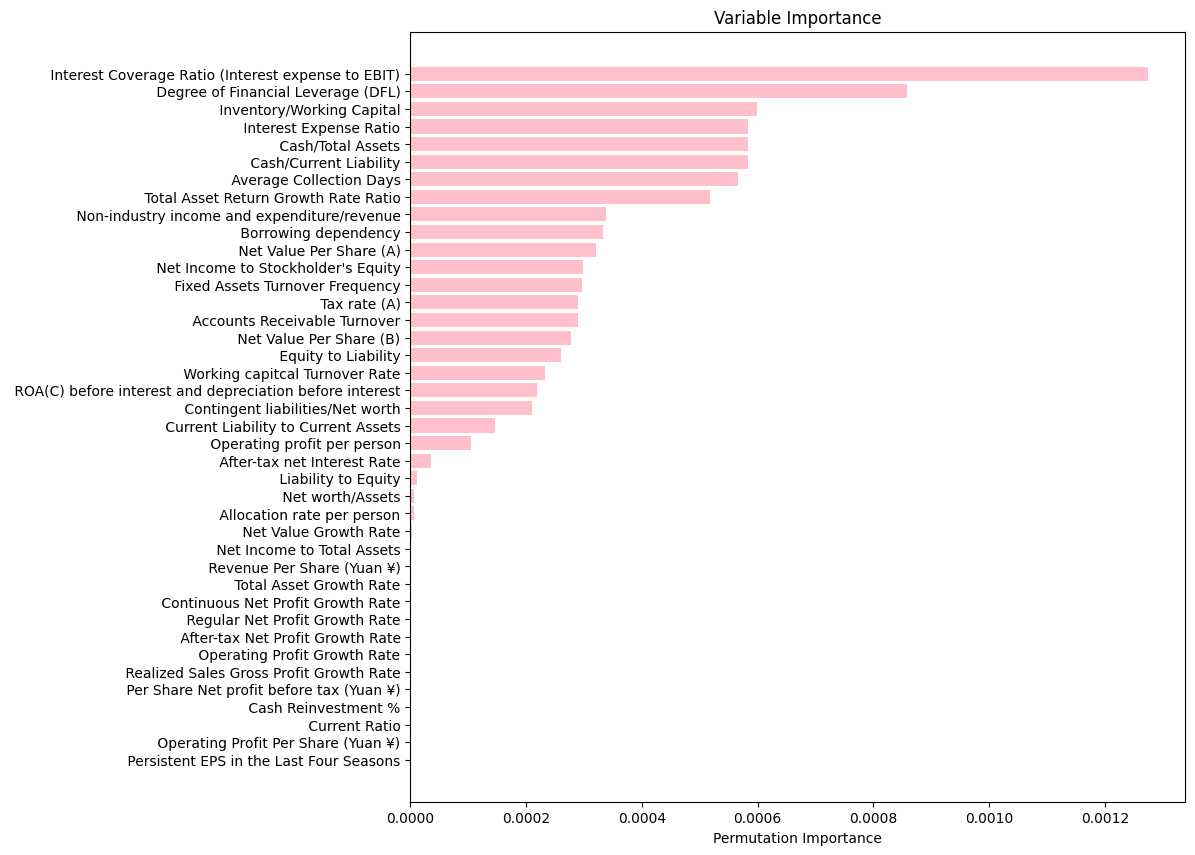

In [10]:
sorted_idx = perm_importance.importances_mean.argsort()
top_vars = 40

x_test = x_test[x_train.columns[sorted_idx][-top_vars:]]
x_valid = x_valid[x_train.columns[sorted_idx][-top_vars:]]
x_train = x_train[x_train.columns[sorted_idx][-top_vars:]]

plt.figure(figsize=(10, 10))
plt.barh(range(top_vars), perm_importance.importances_mean[sorted_idx][-top_vars:], color='pink')
plt.yticks(range(top_vars), x_train.columns)
plt.xlabel('Permutation Importance')
plt.title('Variable Importance')
plt.show()

In [33]:
def show_metrics(y_pred):    
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    roc_auc = roc_auc_score(y_test, y_pred)
    gini = 2 * roc_auc - 1

    print('-'*30)
    print(f'accuracy: {accuracy:.5f}')
    print(f'precision: {precision:.5f}')
    print(f'recall: {recall:.5f}')
    print(f'f1: {f1:.5f}')
    print('-'*30)
    print(f'ROC_AUC: {roc_auc:.5f}')
    print(f'GINI: {gini:.5f}')
    print('-'*30)

## LogisticRegression

In [ ]:
param_distributions = {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'penalty': ['l1', 'l2'],
            'class_weight': ['balanced', None],
            'max_iter': list(range(100, 800, 100)),
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
            }

random_search = RandomizedSearchCV(
    estimator=LogisticRegression(),
    param_distributions=param_distributions,
    scoring='roc_auc',
    n_iter=10,
    cv=5,
    random_state=420,
    n_jobs=-1
)

random_search.fit(x_train, y_train)

best_estimator = random_search.best_estimator_

In [35]:
y_pred_log_reg = best_estimator.predict(x_test)
show_metrics(y_pred_log_reg)

------------------------------
accuracy: 0.87779
precision: 0.19139
recall: 0.86957
f1: 0.31373
------------------------------
ROC_AUC: 0.87382
GINI: 0.74763
------------------------------


## Random Forest

In [ ]:
param_distributions = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(1, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', 'balanced_subsample', None],
    'max_features' : ['auto', 'sqrt', 'log2'],
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=420),
    param_distributions=param_distributions,
    scoring='roc_auc',
    n_iter=10,
    cv=5,
    random_state=420,
    n_jobs=-1
)

random_search.fit(x_train, y_train)

best_estimator = random_search.best_estimator_

In [50]:
y_pred_rand_for = best_estimator.predict(x_test)
show_metrics(y_pred_rand_for)

------------------------------
accuracy: 0.94763
precision: 0.33708
recall: 0.65217
f1: 0.44444
------------------------------
ROC_AUC: 0.80480
GINI: 0.60961
------------------------------


## CatBoost

In [51]:
param_distributions = {
    'eval_metric': ['F1', 'AUC', 'Accuracy', 'Precision', 'Recall'],
    'iterations': [100, 500, 1000],
    'learning_rate' : [0.1, 0.01, 0.001],
    'auto_class_weights' : ['Balanced','SqrtBalanced'],
}

random_search = RandomizedSearchCV(
    CatBoostClassifier(random_state=42, verbose=0), 
    param_distributions=param_distributions,
    scoring='roc_auc',
    n_iter=10,
    cv=5,
    random_state=420,
    n_jobs=-1
)

random_search.fit(x_train, y_train)

best_estimator = random_search.best_estimator_

In [52]:
y_pred_cat = best_estimator.predict(x_test)
show_metrics(y_pred_cat)

------------------------------
accuracy: 0.95810
precision: 0.37931
recall: 0.47826
f1: 0.42308
------------------------------
ROC_AUC: 0.72614
GINI: 0.45229
------------------------------


## ROC Curve

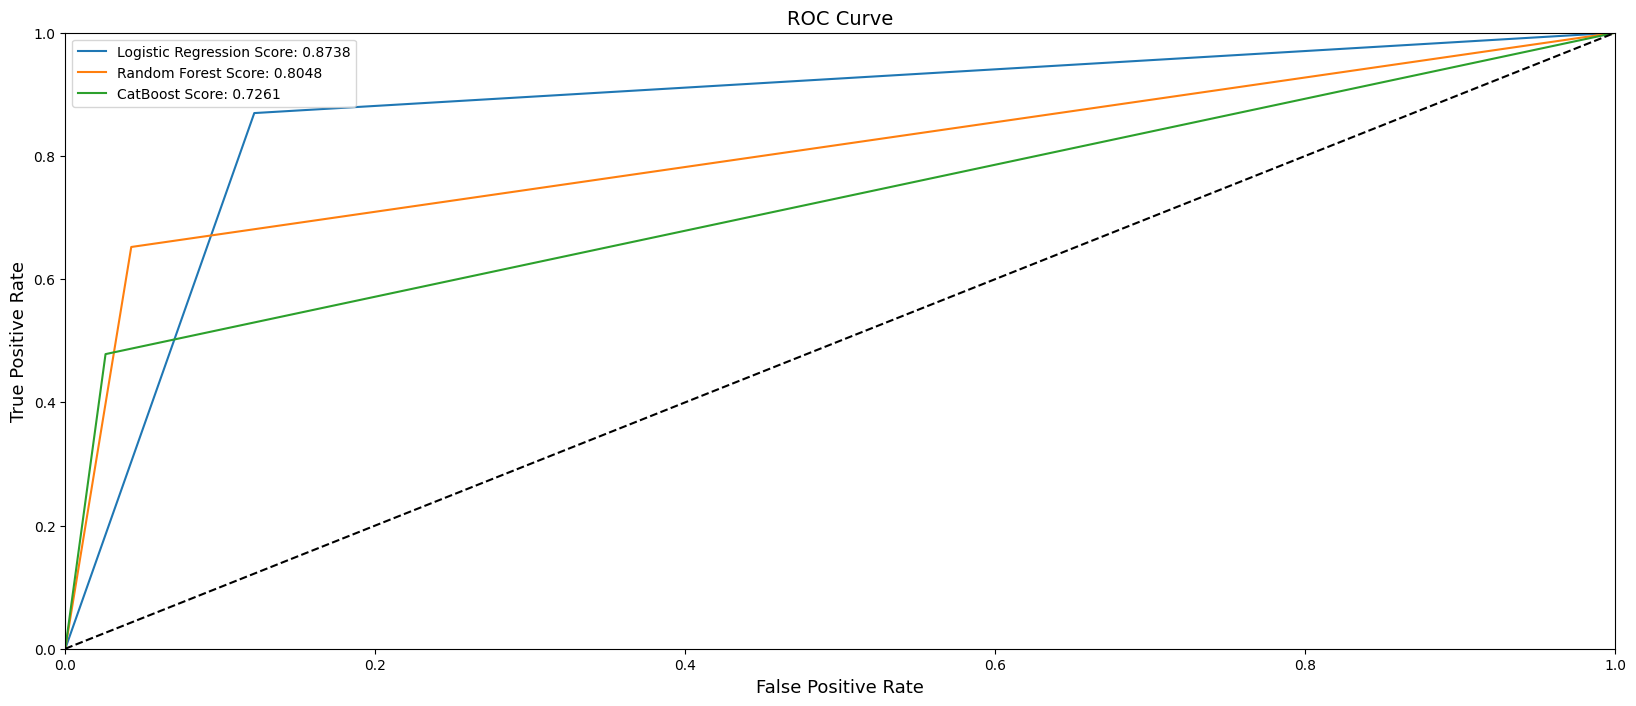

In [54]:
log_fpr, log_tpr, log_thresold = roc_curve(y_test, y_pred_log_reg)
for_fpr, for_tpr, for_thresold = roc_curve(y_test, y_pred_rand_for)
cat_fpr, cat_tpr, cat_thresold = roc_curve(y_test, y_pred_cat)

plt.figure(figsize=(20,8))
plt.title('ROC Curve', fontsize=14)
plt.plot(log_fpr, log_tpr, label=f'Logistic Regression Score: {roc_auc_score(y_test, y_pred_log_reg):.4f}')
plt.plot(for_fpr, for_tpr, label=f'Random Forest Score: {roc_auc_score(y_test, y_pred_rand_for):.4f}')
plt.plot(cat_fpr, cat_tpr, label=f'CatBoost Score: {roc_auc_score(y_test, y_pred_cat):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.legend()
    
plt.show()